パラメタの設定

# Lorenz (1963)モデル

## 非線型前方モデル

Lorenz方程式は強制熱対流を理想化したモデルである。

$$
\begin{align}
\dot{X} &= -\sigma X + \sigma Y \\
\dot{Y} &= -XZ + rX -Y \\
\dot{Z} &= XY - bZ
\end{align}
$$

ここで$\sigma$はPrandtl数，$r$はRayleigh数，$\beta$はアスペクト比を表す。
$X, Y, Z$はそれぞれ無次元化された対流の強さ，最大温度差，対流に伴う成層の変化を表している。

In [4]:
def florenz(w, p, r, b):
    x, y, z = w
    dw = np.zeros_like(w)
    dw[0] =      -p * x + p * y 
    dw[1] = (r - z) * x -     y 
    dw[2] =           x * y     - b * z
    return dw

## 接線型モデル

$$
\begin{align}
\dot{\delta X} &= -\sigma \delta X + \sigma \delta Y \\
\dot{\delta Y} &= -\delta XZ -X\delta Z + r\delta X - \delta Y \\
\dot{\delta Z} &= \delta XY X\delta Y - b\delta Z
\end{align}
$$

In [5]:
def tlorenz(wt, wb, p, r, b):
    dw = np.zeros_like(wt)
    xt, yt, zt = wt
    xb, yb, zb = wb
    dw[0] =       -p * xt +  p * yt 
    dw[1] = (r - zb) * xt -      yt - xb * zt
    dw[2] =       yb * xt + xb * yt -  b * zt
    return dw

## 随伴モデル

$$
\begin{align}
\delta X^{\mathrm{a}} &= \delta X^\mathrm{a} - \sigma\dot{\delta X}^\mathrm{a} + (r-Z)\dot{\delta Y}^\mathrm{a} + Y\dot{\delta Z}^\mathrm{a} \\
\delta Y^{\mathrm{a}} &= \delta Y^{\mathrm{a}} + \sigma\dot{\delta X}^\mathrm{a} - \dot{\delta Y}^\mathrm{a} + X\dot{\delta Z}^\mathrm{a} \\
\delta Z^\mathrm{a} &= \delta Z^\mathrm{a} - X\dot{\delta Y}^\mathrm{a} - b\dot{\delta Z}^\mathrm{a}
\end{align}
$$

In [13]:
def alorenz(wa, dwa, wb, p, r, b):
    xb, yb, zb = wb
    dxa, dya, dza = dwa
    wa[0] += -p * dxa + (r - zb) * dya + yb * dza
    wa[1] +=  p * dxa -            dya + xb * dza
    wa[2] +=          -       xb * dya -  b * dza
    dwa[:] = 0.0
    return wa, dwa

## 時間積分

計算結果をNumpy形式で保存し，最終結果を返す。接線型モデルと随伴モデルは計算に用いる基本場のファイルを読む。時間積分はオイラー法。

In [21]:
def gen_true(nexp, param):
    ifile = f"i{nexp:02}.txt"
    w0 = np.loadtxt(ifile)
    return fom(nexp, 0, w0, param)


def fom(nexp, ncyc, w, param):
    p, r, b, dt, nstop = param
    x = np.zeros([nstop+1, w.size])
    x[0, :] = w
    fname = f"m{nexp:02}c{ncyc:03}.npy"
    for ntim in range(1, nstop+1):
        w += dt * florenz(w, p, r, b)
        x[ntim, :] = w
    np.save(fname, x)
    return w


def tlm(nexp, ncyc, tl, param):
    p, r, b, dt, nstop = param
    fname = f"m{nexp:02}c{ncyc-1:03}.npy"
    wb = np.load(fname)
    for ntim in range(nstop):
        tl += dt * tlorenz(tl, wb[ntim], p, r, b)
    return tl


def adm(nexp, ncyc, wa, param, ltest=False):
    p, r, b, dt, nstop = param
    dwa = np.zeros(3)
    mfile = f"m{nexp:02}c{ncyc-1:03}.npy"
    wb = np.load(mfile)
    if not ltest:
        ofile = f"o{nexp:02}.npy"
        wo = np.load(ofile)
    for ntim in range(nstop, 0, -1):
        if not ltest:
            d = calc_innovation(wb[ntim, :], wo[ntim, :])
            wa += d
        dwa += dt * wa
        wa, dwa = alorenz(wa, dwa, wb[ntim-1], p, r, b)
    return wa

## 観測

予報－観測，コスト函数の計算，観測の生成。

In [10]:
def calc_innovation(wb, wo):
    d = np.zeros(wb.size)
    for i in range(wb.size):
        if wb[i] == miss or wo[i] == miss:
            d[i] = 0.0
        else:
            d[i] = wb[i] - wo[i]
    return d


def calc_cost(nexp, ncyc, nstop):
    mfile = f"m{nexp:02}c{ncyc:03}.npy"
    wb = np.load(mfile)
    ofile = f"o{nexp:02}.npy"
    wo = np.load(ofile)
    cost = 0.0
    for ntim in range(nstop+1):
        d = calc_innovation(wb[ntim, :], wo[ntim, :])
        cost += (d[:]**2).sum()
    return cost * 0.5


def gen_obs(nexp, nstop, iobs):
    rng = np.random.default_rng()
    efile = f"e{nexp:02}.txt"
    e = np.loadtxt(efile)
    ifile = f"i{nexp:02}.txt"
    w0 = np.loadtxt(ifile)
    mfile = f"m{nexp:02}c000.npy"
    wo = np.load(mfile)
    for ntim in range(nstop+1):
        if ntim > 0 and np.mod(ntim, iobs) == 0:
            wo[ntim, :] += e[:] * 2.0 * (rng.random(e.size) - 0.5)
        else:
            wo[ntim, :] = miss
    ofile = f"o{nexp:02}.npy"
    np.save(ofile, wo)
    return calc_cost(nexp, 0, nstop)

## モデルの検証

### 接線型モデル

$\Delta\mathbf w$の摂動を与えて非線型モデル$\mathbf{N}$を時間積分し，その差を接線型モデル$\mathbf{L}$で時間発展させた$\Delta\mathbf w$と比較する。

$$
\mathbf{N}(\mathbf{w} + \Delta\mathbf{w}) - \mathbf{N}(\mathbf{w}) \approx \mathbf{L}(\Delta\mathbf{w})
$$

### 随伴モデル

随伴モデルで時間発展させたモデルの状態ベクトル$\mathbf{X}$の内積と随伴モデル$\mathbf{L}^T$を用いた式とを比較する。

$$
(\mathbf{LX})^T(\mathbf{LX}) = \mathbf{X}^T[\mathbf{L}^T(\mathbf{LX})]
$$

### 勾配

随伴モデルで求めた勾配とコスト函数の差分とを比較する。

$$
\psi(\alpha) = \frac{J(\mathbf{w} - \alpha\nabla J(\mathbf{w})}{\langle -\alpha\nabla J(\mathbf{w}), \nabla J(\mathbf{w})\rangle}  = 1 + O(\alpha)
$$


In [22]:
def test_tlm(nexp, param):
    ncyc = 1
    ifile = f"i{nexp:02}.txt"
    tmp = np.loadtxt(ifile)
    tl = tmp * 0.001
    fw = tmp + tl
    tmp = fom(nexp, ncyc-1, tmp, param)
    fw = fom(nexp, ncyc, fw, param)
    fw -= tmp
    print(f"N(w+dw)-N(w) from NL {fw}")
    tl = tlm(nexp, ncyc, tl, param)
    print(f" L(dw) from TL {tl}")
    ltest = True
    print(f"LX_t LX = {tl @ tl}")
    ad = tl
    ad = adm(nexp, ncyc, ad, param, ltest)
    tmp = np.loadtxt(ifile)
    tl = tmp * 0.001
    pa = tl @ ad
    print(f"X_t (L_t (LX)) = {pa}")


def test_grad(nexp, param):
    na1, na2 = -17, -2
    ltest = False
    ncyc = 1
    ifile = f"i{nexp:02}.txt"
    fw = np.loadtxt(ifile)
    fw = fom(nexp, ncyc, fw, param)
    cost0 = calc_cost(nexp, ncyc, nstop)
    ncyc = 2
    ad = np.zeros(fw.size)
    ad = adm(nexp, ncyc, ad, param, ltest)
    aa = ad @ ad
    chkgra = np.zeros([na2-na1+1])
    for nalpha in range(na1, na2+1):
        alpha = 10.0 ** nalpha
        ifile = f"i{nexp:02}.txt"
        fw = np.loadtxt(ifile)
        fw -= alpha * ad # gradient descent
        fw = fom(nexp, ncyc, fw, param)
        cost1 = calc_cost(nexp, ncyc, nstop)
        chkgra[nalpha-na1] = -(cost1 - cost0) / (alpha * aa)
        print(f"chkgra(10^{nalpha}) = {chkgra[nalpha-na1]}")
    np.savetxt(f"g{nexp:02}.txt", np.column_stack([np.arange(na1, na2+1), chkgra]))

### 変分法データ同化

In [35]:
def run_vda(nexp, nexpi, alpha=5e-4, istart=1, istop=100):
    ltest = False
    if istart < 1:
        sys.exit()
    cost = np.zeros([istop-istart+1])
    for ncyc in range(istart, istop+1):
        if ncyc == 1:
            ifile = f"i{nexpi:02}.txt"
            fw = np.loadtxt(ifile)
        else:
            ad = 0.0
            ad = adm(nexp, ncyc, ad, param, ltest)
            mfile = f"m{nexp:02}c{ncyc-1:03}.npy"
            w = np.load(mfile)
            fw = w[0, :] - alpha * ad
        fw = fom(nexp, ncyc, fw, param)
        cost[ncyc-istart] = calc_cost(nexp, ncyc, nstop)
        print(f"{ncyc}: {cost[ncyc-istart]}")
    np.savetxt(f"j{nexp:02}i{nexpi:02}.txt", np.column_stack(
        [np.arange(istart, istop+1), cost]))

## 実行

パラメタの設定

In [1]:
import sys
import numpy as np

p = 10.0
r = 32.0
b = 8 / 3
nstop = 200
dt = 0.01
miss = 999.999

### 初期値依存性

`i01.txt`

```
1.0
3.0
5.0
```

`i02.txt`

```
1.1
3.3
5.5
```

In [29]:
nstop = 500
param = p, r, b, dt, nstop
x = gen_true(1)
x = gen_true(2)

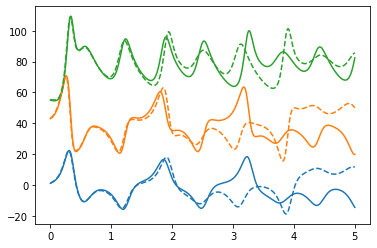

In [31]:
import numpy as np
import matplotlib.pyplot as plt


dt = 0.01
nstop = 500
x = np.linspace(0, dt*nstop, nstop+1)
fname = "m01c000.npy"
w = np.load(fname)
off1, off2 = 40, 50
w[:, 1] += off1
w[:, 2] += off2
fig, ax = plt.subplots()
ax.plot(x, w)
plt.gca().set_prop_cycle(None)
fname = "m02c000.npy"
w = np.load(fname)
w[:, 1] += off1
w[:, 2] += off2
ax.plot(x, w, linestyle="--")

### 接線型モデルと随伴モデルの検証

In [38]:
nstop = 200
param = p, r, b, dt, nstop
test_tlm(1, param)

N(w+dw)-N(w) from NL [ 0.01384879 -0.02533393  0.03898632]
 L(dw) from TL [ 0.01366099 -0.02535304  0.0387748 ]
LX_t LX = 0.0023328842954853917
X_t (L_t (LX)) = 0.0023328842954853895


### 勾配の検証

In [27]:
gen_obs(1, nstop, 60)
test_grad(1, param)

chkgra(10^-17) = -0.0
chkgra(10^-16) = 22.251619228783635
chkgra(10^-15) = 1.8686250176990014
chkgra(10^-14) = 1.3731896960393408
chkgra(10^-13) = 1.0291025485913232
chkgra(10^-12) = 0.999619153113185
chkgra(10^-11) = 1.0001933285070637
chkgra(10^-10) = 0.9999942020648417
chkgra(10^-9) = 1.0000020679425576
chkgra(10^-8) = 0.9999986782869709
chkgra(10^-7) = 0.9999876333543274
chkgra(10^-6) = 0.9998761188907284
chkgra(10^-5) = 0.99876110281068
chkgra(10^-4) = 0.9876069074751608
chkgra(10^-3) = 0.875656082643817
chkgra(10^-2) = -0.2860205691827499


(-2.0, 5.0)

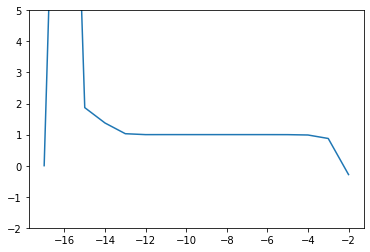

In [33]:
grad = np.loadtxt("g01.txt")
grad = grad.reshape([grad.size//2, 2])

fig, ax = plt.subplots()
ax.plot(grad[:, 0], grad[:, 1])
ax.set_ylim([-2.0, 5.0])

### 変分法データ同化

In [39]:
run_vda(1, 2)

1: 67.83571708814938
2: 24.804130370686376
3: 12.702045483297782
4: 7.537898875969324
5: 4.8987035522504
6: 3.399202065397018
7: 2.4834876337188803
8: 1.8931372218640083
9: 1.4955213939190983
10: 1.2175348699066209
11: 1.016647141429848
12: 0.8670456534945292
13: 0.7525193202806305
14: 0.6625936922884509
15: 0.5903347366956458
16: 0.5310532905190193
17: 0.48151656755590766
18: 0.43945543068986187
19: 0.40324947545842604
20: 0.3717218197897776
21: 0.344003113397125
22: 0.3194400794541673
23: 0.2975331963750112
24: 0.2778937334613673
25: 0.26021381023264484
26: 0.24424532196996193
27: 0.22978496391452183
28: 0.21666348964164162
29: 0.20473793410883645
30: 0.19388592876111657
31: 0.18400150378246866
32: 0.17499195495356917
33: 0.16677547792745331
34: 0.15927935957730874
35: 0.15243857667159905
36: 0.14619469468609197
37: 0.1404949896214932
38: 0.1352917370407531
39: 0.13054162776441372
40: 0.1262052805747563
41: 0.12224683013188967
42: 0.1186335739743612
43: 0.11533566659047452
44: 0.1123

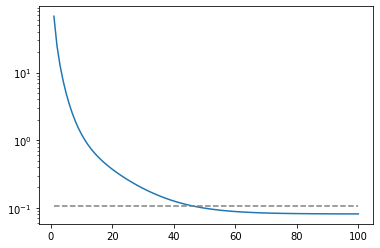

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from l63vda import nstop, calc_cost


costc = calc_cost(1, 0, nstop)
cost = np.loadtxt("j01i02.txt").reshape([100, 2])

fig, ax = plt.subplots()
ax.semilogy(cost[:, 0], cost[:, 1])
ax.plot(cost[:, 0], [costc]*cost[:, 0].size, c="gray", linestyle="--")

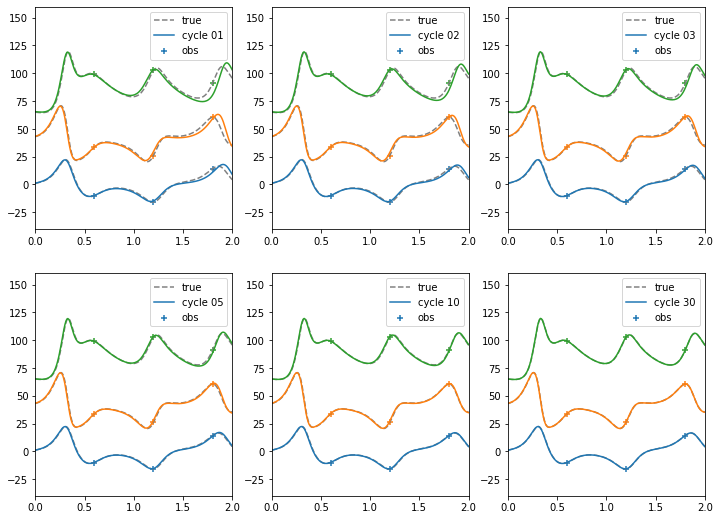

In [40]:
cycles = [1, 2, 3, 5, 10, 30]
x = np.linspace(0, dt * nstop, nstop+1) 

nx, ny = 2, 3
off1, off2 = 40, 60
fig, ax = plt.subplots(nx, ny, figsize=[12, 9])
wtrue = np.load("m01c000.npy")
wtrue[:, 1] += off1
wtrue[:, 2] += off2
wobs = np.load("o01.npy")
wobs[:, 1] += off1
wobs[:, 2] += off2

k = 0
for ncyc in cycles:
    i, j = k // ny, k % ny
    k += 1
    w = np.load(f"m01c{ncyc:03}.npy")
    w[:, 1] += off1
    w[:, 2] += off2
    ax[i, j].plot(x, wtrue, c="gray", linestyle="--", label=["true","",""])
    ax[i, j].plot(x, w, label=[f"cycle {ncyc:02}","",""])
    ax[i, j].set_prop_cycle(None)
    ax[i, j].scatter(x, wobs[:,0], marker="+", label="obs")
    ax[i, j].scatter(x, wobs[:,1], marker="+")
    ax[i, j].scatter(x, wobs[:,2], marker="+")
    ax[i, j].set_xlim([0.0, 2.0])
    ax[i, j].set_ylim([-40, 160])
    ax[i, j].legend(loc="upper right")

# 参考文献
* Lorenz, E. N, 1963: Deterministic nonperiodic flow. _J. Atmos. Sci._, __20__, 130&ndash;141, [doi:10.1175/1520-0469(1963)020<0130:DNF>2.0.CO;2](https://doi.org/10.1175/1520-0469(1963)020<0130:DNF>2.0.CO;2).
* Huang, X.-Y. and X. Yang, 1996: Variational data assimilation with the Lorenz model. [Technical Report 26](http://hirlam.org/index.php/publications-54/hirlam-technical-reports-a/doc_view/1317-hirlam-technical-report-no-26), HIRAM, April 1996, 44 pp.